In [1]:
%matplotlib inline
import seaborn as sns
import librosa, librosa.display
import numpy as np
import scipy
import IPython.display as ipd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 5)

In [2]:
filename = 'music_samples/simple_piano.wav'
x, sr = librosa.load(filename)

In [3]:
ipd.Audio(x, rate=sr)

Display the CQT in signal

In [4]:
bins_per_octave = 36
cqt = librosa.cqt(x, sr=sr, n_bins=300, bins_per_octave=bins_per_octave)
log_cqt = librosa.amplitude_to_db(np.abs(cqt))

In [5]:
cqt.shape

(300, 166)

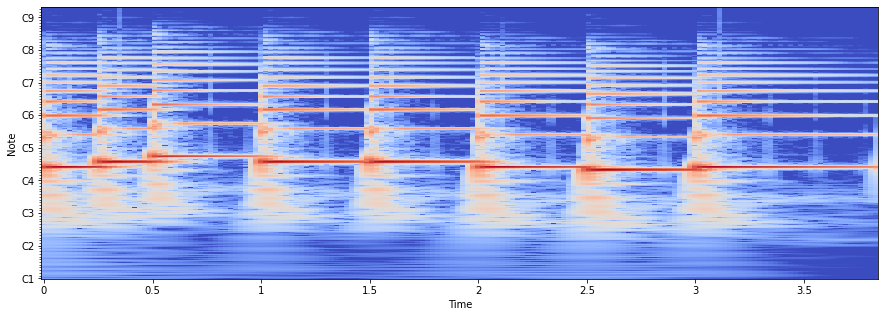

In [6]:
librosa.display.specshow(log_cqt, sr=sr, x_axis='time', y_axis='cqt_note', 
                         bins_per_octave=bins_per_octave)

In [7]:
hop_length = 10
onset_env = librosa.onset.onset_strength(x, sr=sr, hop_length=hop_length)

C:\Users\Asif\AppData\Local\Temp\ipykernel_9940\3875805446.py:2: FutureWarning: Pass y=[-0.00094604 -0.00531006 -0.01434326 ...  0.02850342  0.03570557
  0.02514648] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  onset_env = librosa.onset.onset_strength(x, sr=sr, hop_length=hop_length)


(0.0, 8493.0)

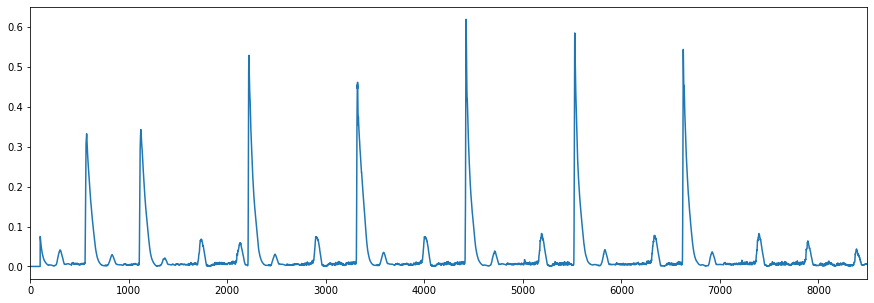

In [8]:
plt.plot(onset_env)
plt.xlim(0, len(onset_env))

In [9]:
onset_samples = librosa.onset.onset_detect(x,
                                           sr=sr, units='samples', 
                                           hop_length=hop_length, 
                                           backtrack=False,
                                           pre_max=20,
                                           post_max=20,
                                           pre_avg=100,
                                           post_avg=100,
                                           delta=0.2,
                                           wait=0)

C:\Users\Asif\AppData\Local\Temp\ipykernel_9940\3699890969.py:1: FutureWarning: Pass y=[-0.00094604 -0.00531006 -0.01434326 ...  0.02850342  0.03570557
  0.02514648] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  onset_samples = librosa.onset.onset_detect(x,


In [10]:
onset_samples

array([ 5740, 11240, 22210, 33230, 44240, 55270, 66280])

In [11]:
onset_boundaries = np.concatenate([[0], onset_samples, [len(x)]])

In [12]:
print(onset_boundaries)

[    0  5740 11240 22210 33230 44240 55270 66280 84928]


In [13]:
onset_times = librosa.samples_to_time(onset_boundaries, sr=sr)

In [14]:
onset_times

array([0.        , 0.26031746, 0.50975057, 1.00725624, 1.50702948,
       2.00634921, 2.50657596, 3.00589569, 3.85160998])

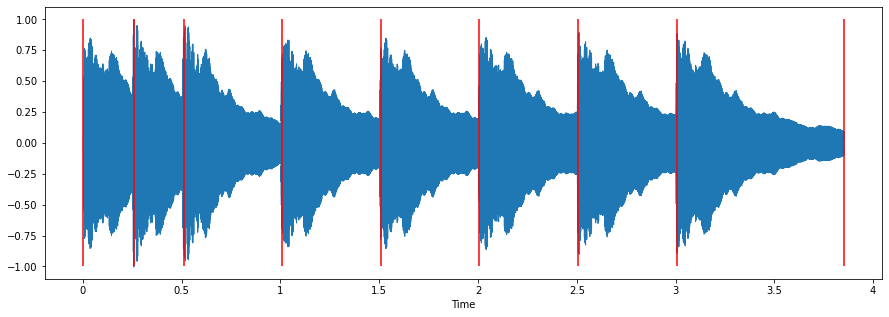

In [15]:
librosa.display.waveshow(x, sr=sr)
plt.vlines(onset_times, -1, 1, color='r')

Estimate notes

In [16]:
def estimate_note(segment, sr, fmin=50.0, fmax=2000.0):
    
    # Find autocorrelation of a given segment
    r = librosa.autocorrelate(segment)
    
    # Define lower and upper limits for the autocorrelation argmax.
    i_min = sr/fmax
    i_max = sr/fmin
    r[:int(i_min)] = 0
    r[int(i_max):] = 0
    
    # Find the location of the maximum autocorrelation.
    i = r.argmax()
    f0 = float(sr)/i
    return f0

In [17]:
print("Freqs")
for i in range(len(onset_boundaries)-1):
    n0 = onset_boundaries[i]
    n1 = onset_boundaries[i+1]
    f0 = estimate_note(x[n0:n1], sr)
    print(f0)

Freqs
350.0
393.75
441.0
393.75
393.75
350.0
329.1044776119403
350.0


In [18]:
def generate_sine(f0, sr, n_duration):
    n = np.arange(n_duration)
    return 0.2*np.sin(2*np.pi*f0*n/float(sr))

In [19]:
def estimate_note_and_generate_sine(x, onset_samples, i, sr):
    n0 = onset_samples[i]
    n1 = onset_samples[i+1]
    f0 = estimate_note(x[n0:n1], sr)
    return generate_sine(f0, sr, n1-n0)

In [20]:
for i in range(len(onset_boundaries) - 1):
    print(estimate_note_and_generate_sine(x, onset_boundaries, i, sr=sr))

[0.         0.01991357 0.03962923 ... 0.07768696 0.0956508  0.11266401]
[0.         0.0223929  0.04450419 ... 0.16934484 0.18019377 0.18877667]
[0.         0.02506665 0.04973798 ... 0.16886559 0.15410265 0.13690942]
[ 0.          0.0223929   0.04450419 ... -0.19874244 -0.2
 -0.19874244]
[ 0.          0.0223929   0.04450419 ... -0.06605581 -0.08677675
 -0.10640642]
[0.         0.01991357 0.03962923 ... 0.03962923 0.05895103 0.07768696]
[0.         0.0187283  0.03729201 ... 0.19556429 0.19078252 0.18432414]
[ 0.          0.01991357  0.03962923 ... -0.05895103 -0.03962923
 -0.01991357]


In [21]:
y = np.concatenate([
    estimate_note_and_generate_sine(x, onset_boundaries, i, sr=sr)
    for i in range(len(onset_boundaries)-1)
])

In [22]:
ipd.Audio(y, rate=sr)

In [23]:
cqt = librosa.cqt(y, sr=sr)

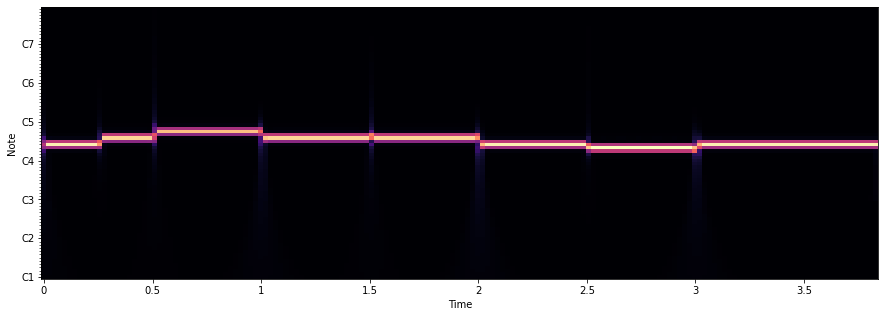

In [24]:
librosa.display.specshow(abs(cqt), sr=sr, x_axis='time', y_axis='cqt_note')